In [1]:
!pip install numpy pandas networkx matplotlib ipywidgets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 9.9 MB/s eta 0:00:00


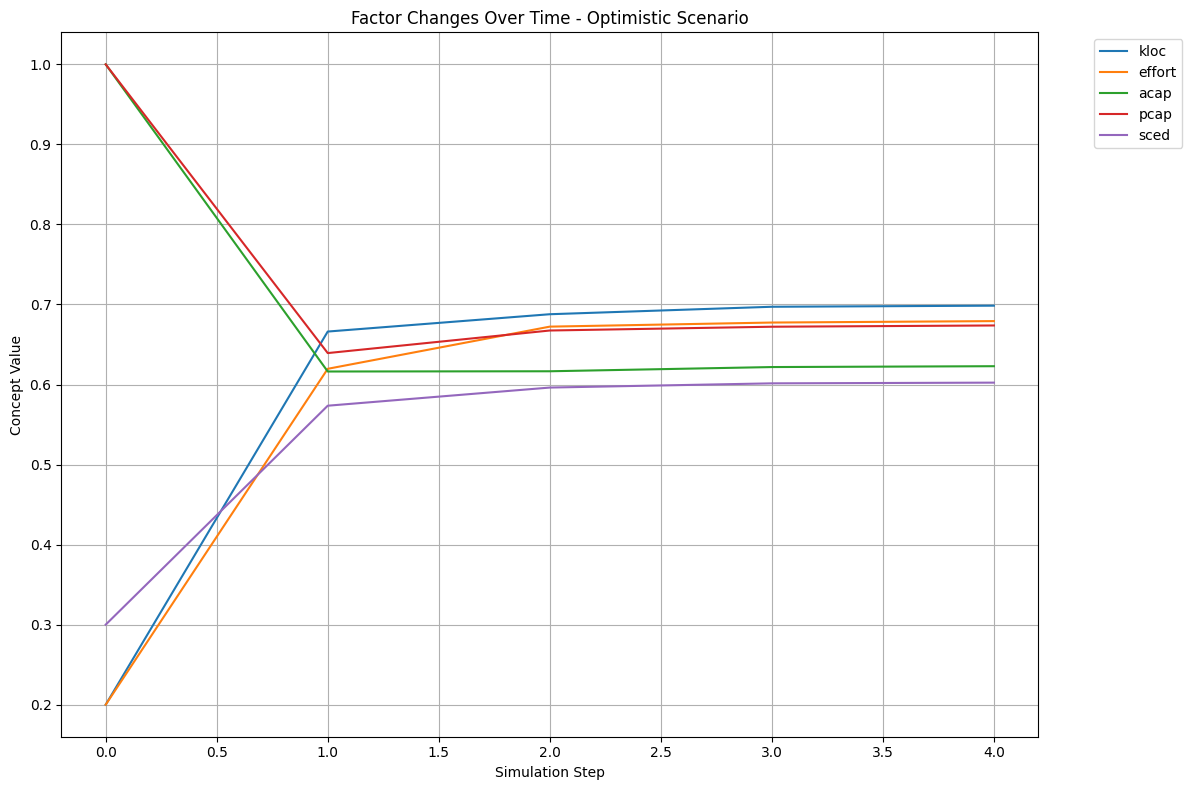

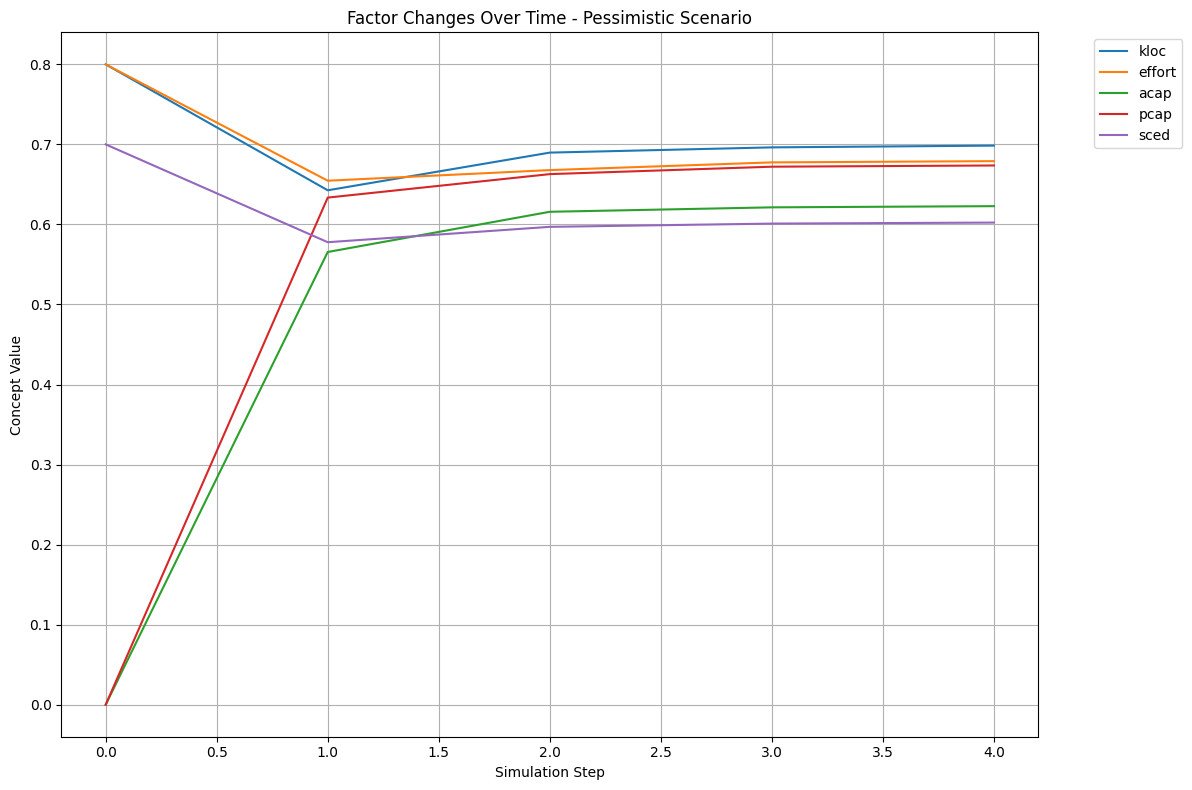

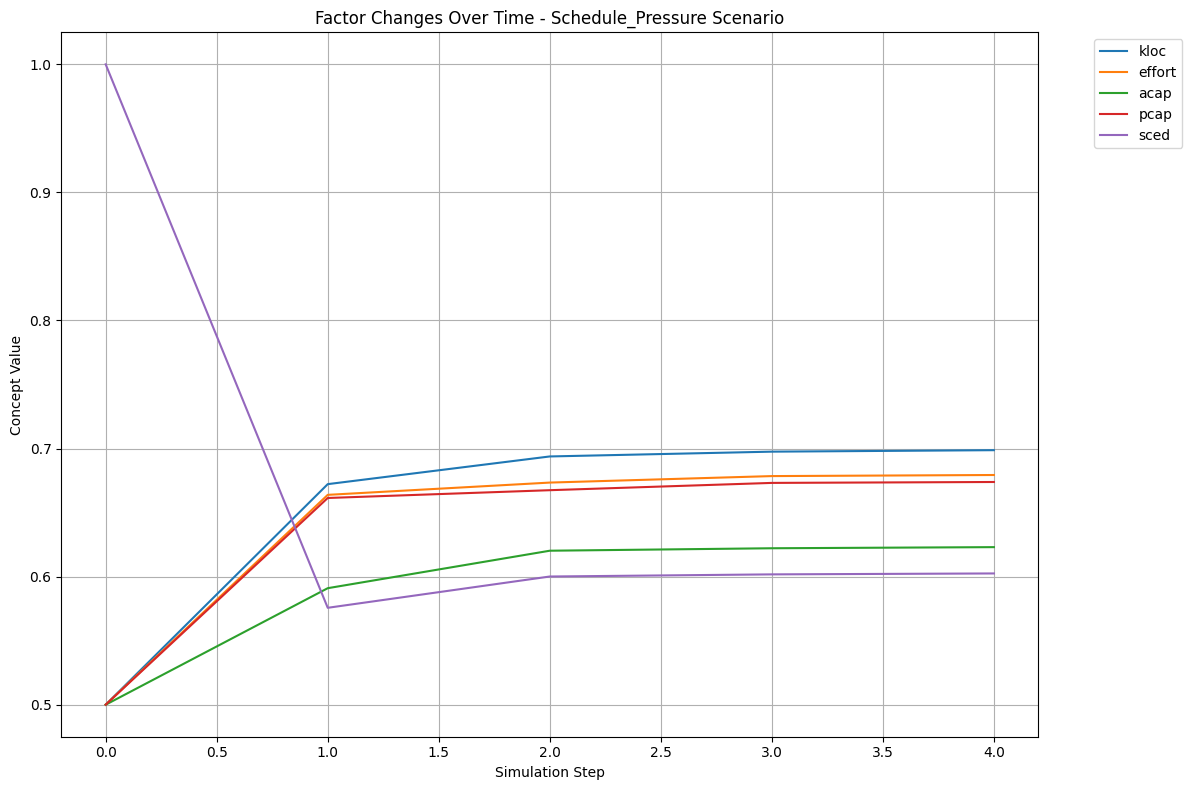

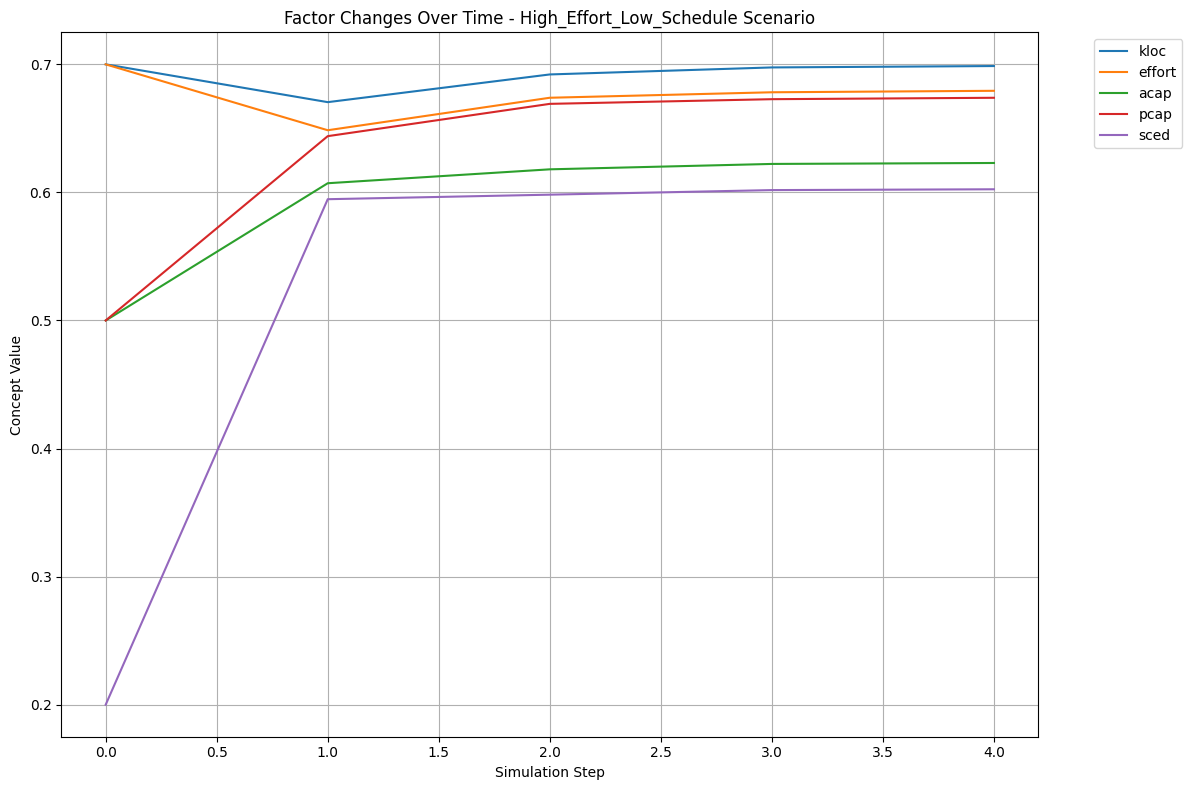

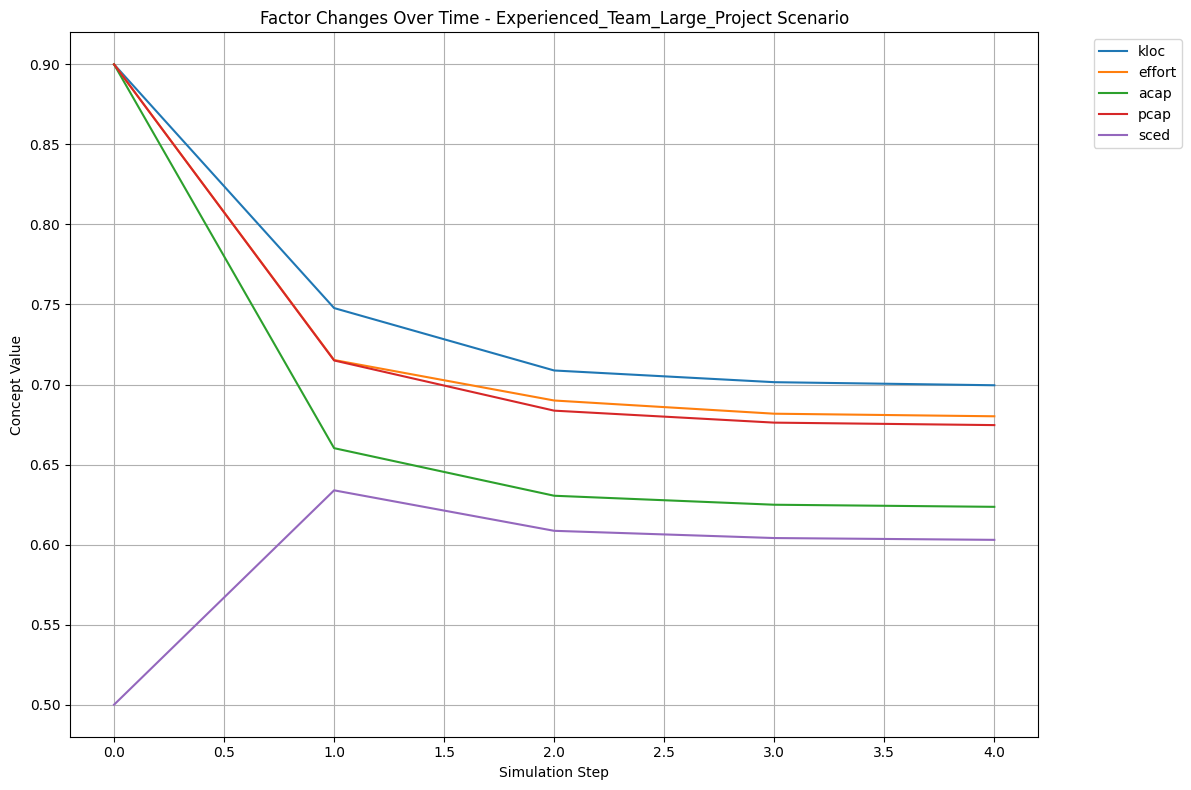

In [13]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from scipy.io import arff
from sklearn.preprocessing import MinMaxScaler
from ipywidgets import interact, IntSlider, widgets

pd.options.mode.chained_assignment = None  # default='warn'

# -----------------------------------------
# Data Loading and Preprocessing Functions
# -----------------------------------------
def load_and_preprocess_data(file_path, features, category_mapping):
    """
    Load and preprocess the NASA 93 dataset.
    Args:
        file_path (str): Path to the ARFF file.
        features (list): List of relevant features to extract.
        category_mapping (dict): Mapping for categorical variables.
    Returns:
        pd.DataFrame: Preprocessed and scaled dataset.
    """
    # Load NASA 93 dataset
    data_raw, _ = arff.loadarff(file_path)
    df = pd.DataFrame(data_raw)

    # Select relevant features
    data = df[features]

    # Map categorical variables to numerical codes
    for col in ['acap', 'pcap', 'sced']:
        data[col] = data[col].map(category_mapping)

    # Convert 'kloc' and 'effort' to float and handle missing values
    data['kloc'] = data['kloc'].astype(float)
    data['effort'] = data['effort'].astype(float)
    data.dropna(inplace=True)

    # Normalize data using MinMaxScaler for FCM purposes
    scaler = MinMaxScaler()
    data_normalized = pd.DataFrame(scaler.fit_transform(data), columns=features)

    return data_normalized

# -----------------------------------------
# Fuzzy Cognitive Map (FCM) Functions
# -----------------------------------------
def construct_adjacency_matrix(data):
    """
    Constructs the adjacency matrix based on the correlation matrix.
    Args:
        data (pd.DataFrame): Preprocessed data.
    Returns:
        np.ndarray: Adjacency matrix.
    """
    correlation_matrix = data.corr().to_numpy()
    np.fill_diagonal(correlation_matrix, 0)  # No self-influence
    return correlation_matrix

def sigmoid(x):
    """ Sigmoid activation function. """
    return 1 / (1 + np.exp(-x))

def run_fcm_simulation(adjacency_matrix, initial_state, steps=5):
    """
    Runs an FCM simulation over the given number of steps.
    Args:
        adjacency_matrix (np.ndarray): The FCM adjacency matrix.
        initial_state (np.ndarray): Initial state vector for the concepts.
        steps (int): Number of steps for simulation.
    Returns:
        np.ndarray: States over time for each concept.
    """
    num_concepts = len(initial_state)
    states = np.zeros((steps, num_concepts))
    states[0] = initial_state

    for step in range(1, steps):
        inputs = np.dot(adjacency_matrix.T, states[step - 1])
        states[step] = sigmoid(inputs)

    return states

# -----------------------------------------
# FCM state Change Graph
# -----------------------------------------

def plot_fcm_states(scenario_states, features):
    """
    Plots the changes in each factor (concept) over each step for all scenarios.
    Args:
        scenario_states (dict): FCM simulation results for each scenario.
        features (list): List of feature names.
    """
    for scenario_name, states in scenario_states.items():
        plt.figure(figsize=(12, 8))
        for i, feature in enumerate(features):
            plt.plot(states[:, i], label=feature)
        plt.title(f"Factor Changes Over Time - {scenario_name} Scenario")
        plt.xlabel("Simulation Step")
        plt.ylabel("Concept Value")
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.grid(True)
        plt.tight_layout()
        plt.show()

# -----------------------------------------
# Main Code and Execution
# -----------------------------------------
if __name__ == "__main__":
    # Define features and category mappings
    features = ['kloc', 'effort', 'acap', 'pcap', 'sced']
    category_mapping = {b'vl': 0, b'l': 1, b'n': 2, b'h': 3, b'vh': 4}

    # Load and preprocess data
    file_path = 'nasa93-dem.arff'
    data_normalized = load_and_preprocess_data(file_path, features, category_mapping)

    # Construct adjacency matrix
    adjacency_matrix = construct_adjacency_matrix(data_normalized)

    # Define initial states for different scenarios
    initial_states = {
      'Optimistic': np.array([0.2, 0.2, 1.0, 1.0, 0.3]),
      'Pessimistic': np.array([0.8, 0.8, 0.0, 0.0, 0.7]),
      'Schedule_Pressure': np.array([0.5, 0.5, 0.5, 0.5, 1.0]),
      'High_Effort_Low_Schedule': np.array([0.7, 0.7, 0.5, 0.5, 0.2]),
      'Experienced_Team_Large_Project': np.array([0.9, 0.9, 0.9, 0.9, 0.5])
    }

    # Run FCM simulations
    scenario_states = {}
    for scenario_name, initial_state in initial_states.items():
        scenario_states[scenario_name] = run_fcm_simulation(adjacency_matrix, initial_state)

    # Plot factor changes for each scenario
    plot_fcm_states(scenario_states, features)
